### Check GPU 

In [1]:
import tensorflow as tf

In [2]:
 tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1700362142813845868
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4174381056
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12190966326498828312
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


### DL Models

In [4]:
# necessary libraries
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers

from keras.models import Model, Sequential
from keras import layers

In [5]:
# visulization function for Models
def visualize(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].plot(epochs, acc, 'r', label='Training acc')
    axs[0].plot(epochs, val_acc, 'b', label='Validation acc')
    axs[0].set_title('Training and validation accuracy')
    axs[0].legend()
    
    axs[1].plot(epochs, loss, 'r', label='Training loss')
    axs[1].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[1].set_title('Training and validation loss')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()


In [24]:
# directories
training_dir="seg_train/seg_train"
validation_dir="seg_test/seg_test"

In [25]:
# use this function for preparing data 

def prep_data(augmented,batch_size=32):    
    if augmented:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)
    
        validation_datagen = ImageDataGenerator(rescale=1./255)    

    else:
        train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
        validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

    # training set
    train_set = train_datagen.flow_from_directory(
        training_dir,
        target_size=(150, 150),  # The dimensions to which all images found will be resized
        batch_size=batch_size,# 32  default
        class_mode="sparse") # you can change this to onehotEncoded format or another format
         
    
    # validation set
    validation_set = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=batch_size,  # 32 default
        class_mode="sparse")
             
    return train_set , validation_set


In [26]:
# augmented train dataset
augmented_train_set,validation_set=prep_data(True)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [27]:
# not augmented train set
straight_train_set,validation_set=prep_data(False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


### Some example images from Normal Train Dataset (Not augmented)

In [10]:
# not augmented dataset

images,labels=straight_train_set.next()

class_names = straight_train_set.class_indices
class_names = {v: k for k, v in class_names.items()}

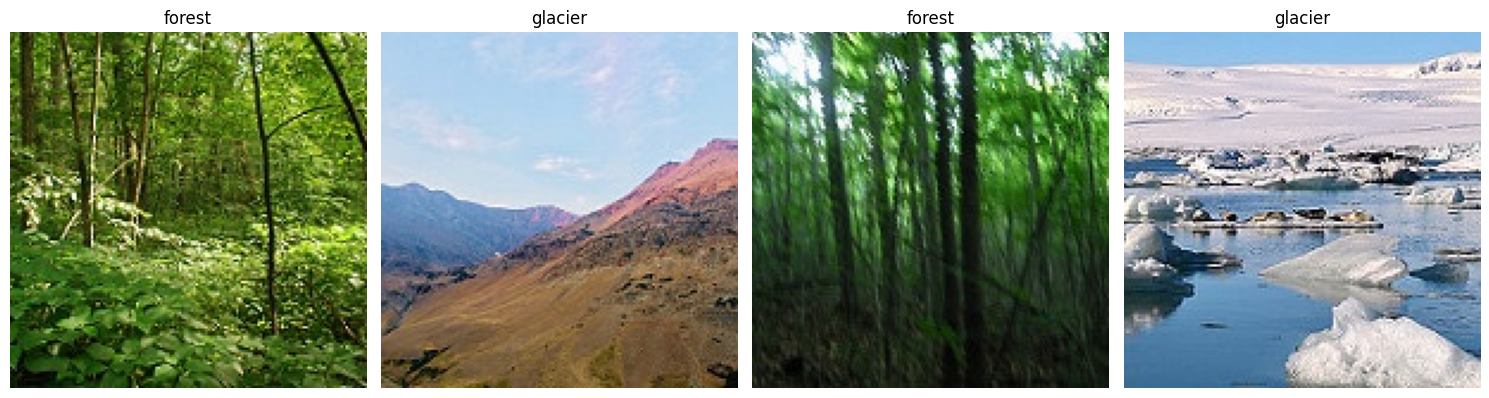

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    axes[i].imshow(images[i]) 
    label_index = int(labels[i])
    class_name = class_names[label_index]
    axes[i].set_title(f"{class_name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Some Example Images from Augmented Train Dataset

In [12]:
# augmented dataset
images,labels=augmented_train_set.next()

class_names = augmented_train_set.class_indices
class_names = {v: k for k, v in class_names.items()}

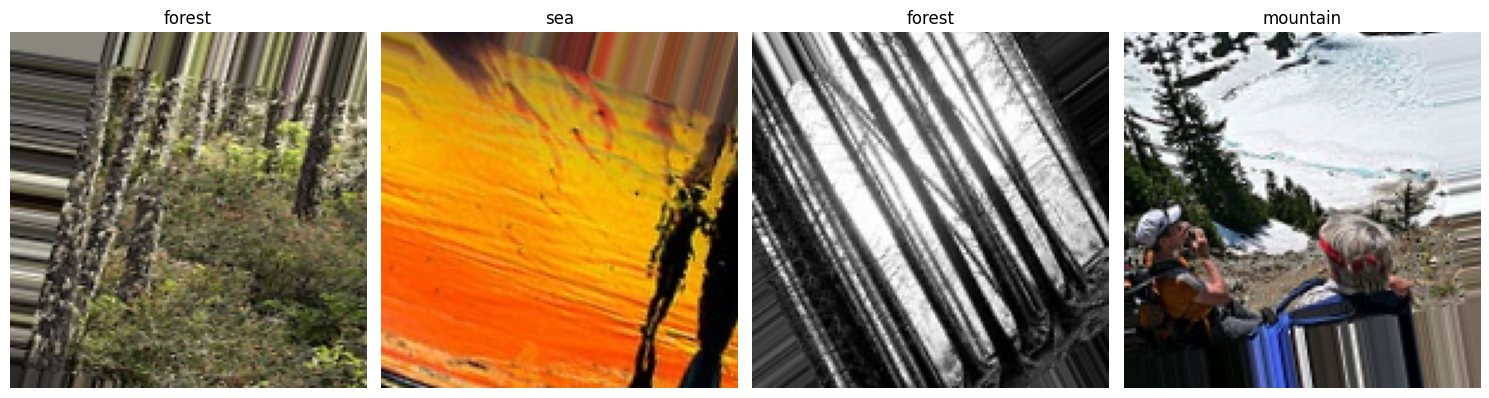

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    axes[i].imshow(images[i]) 
    label_index = int(labels[i])
    class_name = class_names[label_index]
    axes[i].set_title(f"{class_name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Model 1.1 Simple CNN Model (without augmentation)

In [16]:
train_set,validation_set=prep_data(False) # set false for not augmented data

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [17]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(6, activation='softmax'))

In [18]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    loss='sparse_categorical_crossentropy', # labels are in integer form
    metrics=['accuracy'])

In [19]:
history = model.fit(
    train_set,
    epochs=10,
    validation_data=validation_set,)

Epoch 1/10
439/439 [==============================] - 17s 37ms/step - loss: 1.0925 - accuracy: 0.5756 - val_loss: 0.9213 - val_accuracy: 0.6460
Epoch 2/10
439/439 [==============================] - 16s 37ms/step - loss: 0.8306 - accuracy: 0.6912 - val_loss: 0.7473 - val_accuracy: 0.7327
Epoch 3/10
439/439 [==============================] - 17s 38ms/step - loss: 0.7018 - accuracy: 0.7418 - val_loss: 0.6856 - val_accuracy: 0.7577
Epoch 4/10
439/439 [==============================] - 16s 37ms/step - loss: 0.6259 - accuracy: 0.7740 - val_loss: 0.5896 - val_accuracy: 0.7900
Epoch 5/10
439/439 [==============================] - 17s 38ms/step - loss: 0.5652 - accuracy: 0.8006 - val_loss: 0.5409 - val_accuracy: 0.8107
Epoch 6/10
439/439 [==============================] - 16s 37ms/step - loss: 0.5139 - accuracy: 0.8173 - val_loss: 0.5139 - val_accuracy: 0.8180
Epoch 7/10
439/439 [==============================] - 17s 38ms/step - loss: 0.4747 - accuracy: 0.8340 - val_loss: 0.4758 - val_accuracy:

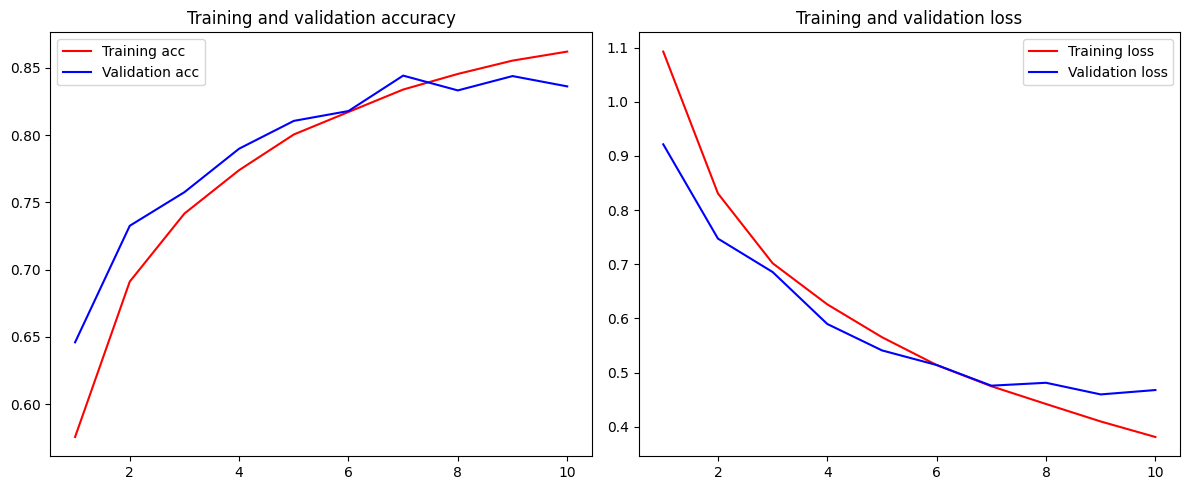

In [20]:
visualize(history)

model is overfitting , i will use data augmentation to try to prevent overfitting

## Model 1.2 Simple CNN model with Data Augmentation

In [149]:
train_set,validation_set=prep_data(True) # set True for  augmented data

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [150]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(6, activation='softmax'))

In [151]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    loss='sparse_categorical_crossentropy', # labels are in integer form
    metrics=['accuracy'])

In [152]:
# model and compile settings are same , i will directly fit data 
history1_2 = model.fit(
    train_set,
    epochs=10,
    validation_data=validation_set,
    validation_steps=50)

Epoch 1/10
439/439 [==============================] - 62s 140ms/step - loss: 1.2547 - accuracy: 0.4996 - val_loss: 1.0622 - val_accuracy: 0.5906
Epoch 2/10
439/439 [==============================] - 64s 147ms/step - loss: 1.0419 - accuracy: 0.6053 - val_loss: 0.9055 - val_accuracy: 0.6769
Epoch 3/10
439/439 [==============================] - 64s 147ms/step - loss: 0.9470 - accuracy: 0.6412 - val_loss: 1.0363 - val_accuracy: 0.6112
Epoch 4/10
439/439 [==============================] - 62s 142ms/step - loss: 0.8913 - accuracy: 0.6648 - val_loss: 0.7172 - val_accuracy: 0.7437
Epoch 5/10
439/439 [==============================] - 62s 140ms/step - loss: 0.8430 - accuracy: 0.6880 - val_loss: 0.8028 - val_accuracy: 0.7256
Epoch 6/10
439/439 [==============================] - 61s 138ms/step - loss: 0.8086 - accuracy: 0.7065 - val_loss: 0.6358 - val_accuracy: 0.7763
Epoch 7/10
439/439 [==============================] - 61s 140ms/step - loss: 0.7798 - accuracy: 0.7158 - val_loss: 0.7068 - val_ac

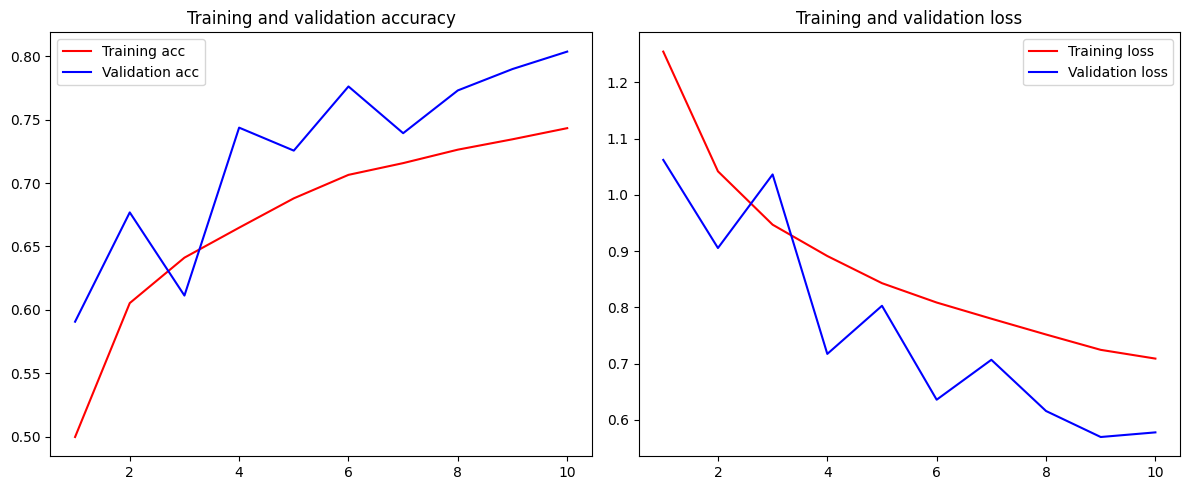

In [154]:
visualize(history1_2)

In [ ]:
0.72 0.73

i prevent overfitting but accuracy reduced , i will try with more epoch

### Model 1.3 CNN Model with data augmentation with more epochs

In [164]:
train_set,validation_set=prep_data(True) # set True for  augmented data

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [165]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(6, activation='softmax'))

In [166]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    loss='sparse_categorical_crossentropy', # labels are in integer form
    metrics=['accuracy'])

In [167]:
# model and compile settings are same , i will directly fit data 
# bunu zaman oldugunda tekrar train le , bu halinde validation step vardı
history1_3 = model.fit(
    train_set,
    epochs=25,
    validation_data=validation_set,
    )

Epoch 1/25
439/439 [==============================] - 62s 139ms/step - loss: 1.2607 - accuracy: 0.4944 - val_loss: 1.3120 - val_accuracy: 0.5427
Epoch 2/25
439/439 [==============================] - 62s 140ms/step - loss: 1.0558 - accuracy: 0.5957 - val_loss: 0.8953 - val_accuracy: 0.6740
Epoch 3/25
439/439 [==============================] - 60s 135ms/step - loss: 0.9581 - accuracy: 0.6395 - val_loss: 0.7939 - val_accuracy: 0.7153
Epoch 4/25
439/439 [==============================] - 60s 136ms/step - loss: 0.8920 - accuracy: 0.6647 - val_loss: 0.7317 - val_accuracy: 0.7370
Epoch 5/25
439/439 [==============================] - 61s 140ms/step - loss: 0.8506 - accuracy: 0.6865 - val_loss: 0.7450 - val_accuracy: 0.7293
Epoch 6/25
439/439 [==============================] - 60s 137ms/step - loss: 0.8071 - accuracy: 0.7022 - val_loss: 0.8104 - val_accuracy: 0.6957
Epoch 7/25
439/439 [==============================] - 60s 137ms/step - loss: 0.7792 - accuracy: 0.7163 - val_loss: 0.6565 - val_ac

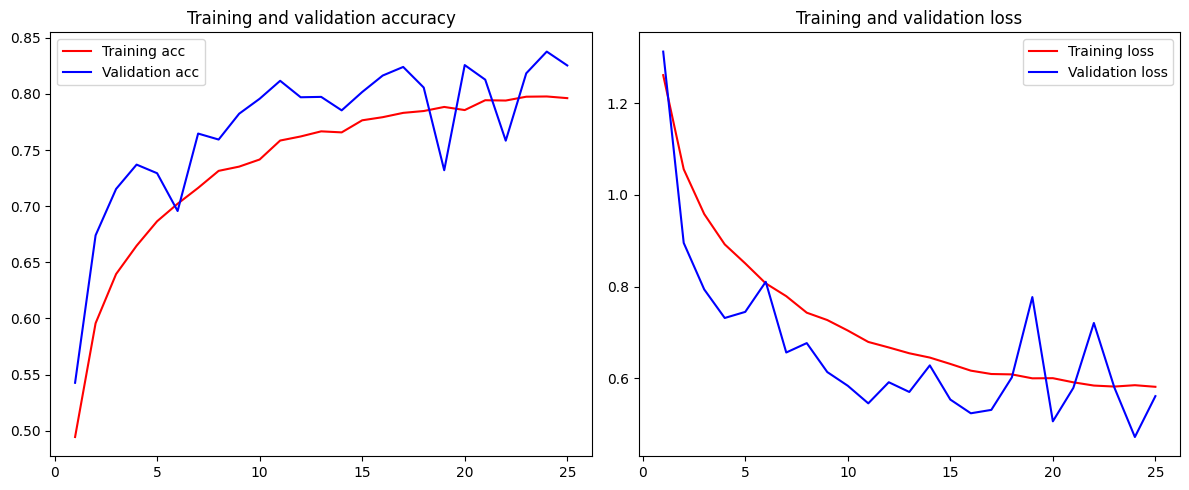

In [169]:
visualize(history1_3)

### Model 2.1 More Complex CNN model

In [10]:
train_set,validation_set=prep_data(False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [11]:
# MORE COMPLEX MODEL 

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

In [12]:

model.compile(optimizer= tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [13]:
model2_1 = model.fit(
    train_set,
    epochs=20,
    validation_data=validation_set,
        )

Epoch 1/20
439/439 [==============================] - 129s 283ms/step - loss: 1.2377 - accuracy: 0.5044 - val_loss: 0.9562 - val_accuracy: 0.6277
Epoch 2/20
439/439 [==============================] - 16s 37ms/step - loss: 0.9391 - accuracy: 0.6444 - val_loss: 0.9694 - val_accuracy: 0.6683
Epoch 3/20
439/439 [==============================] - 17s 39ms/step - loss: 0.7827 - accuracy: 0.7148 - val_loss: 0.6745 - val_accuracy: 0.7543
Epoch 4/20
439/439 [==============================] - 17s 39ms/step - loss: 0.6917 - accuracy: 0.7571 - val_loss: 0.6312 - val_accuracy: 0.7713
Epoch 5/20
439/439 [==============================] - 19s 43ms/step - loss: 0.6128 - accuracy: 0.7815 - val_loss: 0.5397 - val_accuracy: 0.8107
Epoch 6/20
439/439 [==============================] - 17s 39ms/step - loss: 0.5754 - accuracy: 0.8009 - val_loss: 0.5552 - val_accuracy: 0.8070
Epoch 7/20
439/439 [==============================] - 16s 37ms/step - loss: 0.5254 - accuracy: 0.8149 - val_loss: 0.5843 - val_accurac

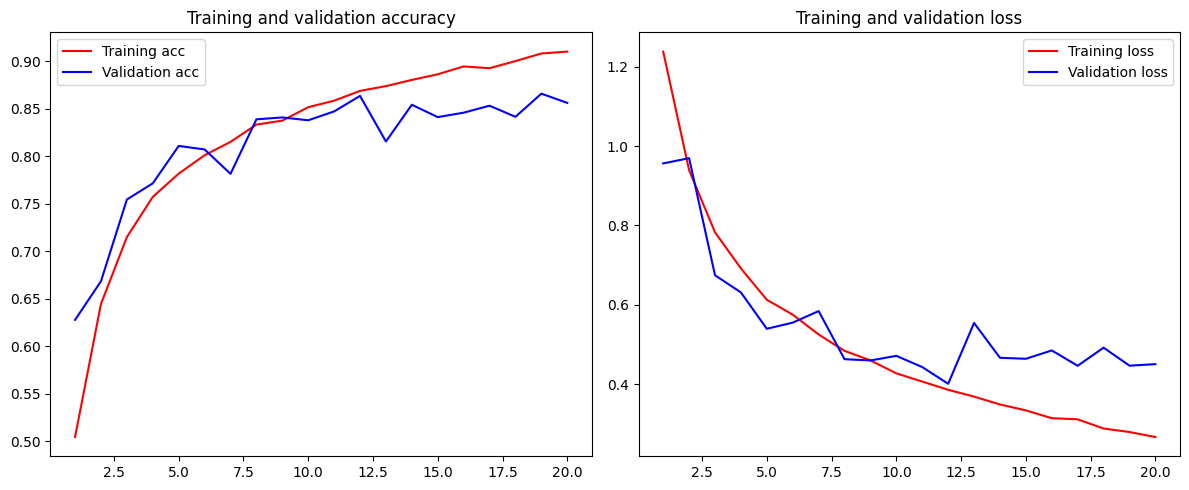

In [14]:
visualize(model2_1)

## Pretrained Models

i am gonna  use VGG16 model 

In [15]:
from tensorflow.keras.applications import VGG16

### Model 3.1 Feature Extraction

In [65]:
train_set,validation_set=prep_data(False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [48]:
conv_base = VGG16(
    weights='imagenet',   # one of None (random initialization), "imagenet" (pre-training on ImageNet), or the path to the weights file to be loaded.
    include_top=False,     #  whether to include the 3 fully-connected layers at the top of the network.
    input_shape=(150, 150, 3))

In [49]:
# in this part i am gonna do feature extraction therefore i set layers to untrainable
for layer in conv_base.layers:
     layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [50]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

In [51]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [19]:
# early stopping
callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

In [53]:
history3_1 = model.fit(
    train_set,
    epochs=20,
    validation_data=validation_set,
    callbacks=[callback])

Epoch 1/20
439/439 [==============================] - 54s 121ms/step - loss: 0.5942 - accuracy: 0.7841 - val_loss: 0.3756 - val_accuracy: 0.8643
Epoch 2/20
439/439 [==============================] - 53s 121ms/step - loss: 0.4066 - accuracy: 0.8563 - val_loss: 0.3830 - val_accuracy: 0.8590
Epoch 3/20
439/439 [==============================] - 53s 122ms/step - loss: 0.3601 - accuracy: 0.8752 - val_loss: 0.3329 - val_accuracy: 0.8783
Epoch 4/20
439/439 [==============================] - 53s 122ms/step - loss: 0.3309 - accuracy: 0.8848 - val_loss: 0.3377 - val_accuracy: 0.8797
Epoch 5/20
439/439 [==============================] - 53s 121ms/step - loss: 0.3050 - accuracy: 0.8942 - val_loss: 0.3264 - val_accuracy: 0.8823
Epoch 6/20
439/439 [==============================] - 53s 121ms/step - loss: 0.2891 - accuracy: 0.9002 - val_loss: 0.3404 - val_accuracy: 0.8800
Epoch 7/20
439/439 [==============================] - 53s 121ms/step - loss: 0.2646 - accuracy: 0.9073 - val_loss: 0.3418 - val_ac

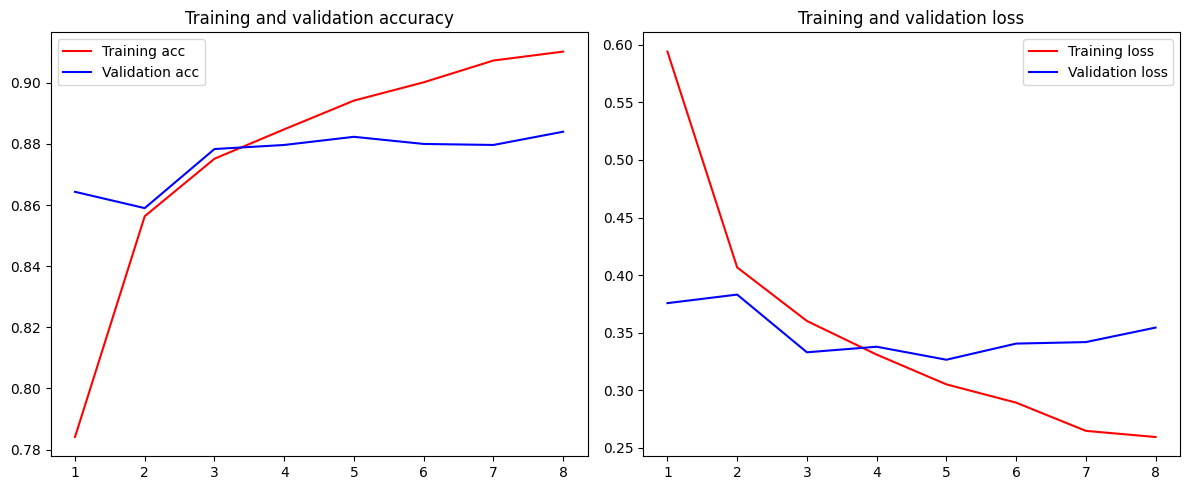

In [54]:
visualize(history3_1)

Training accuracy : 0.9102 
Validation Accuracy : 0.8840

### Model 3.2 Feature Extraction with Data Augmentation

In [71]:
train_set,validation_set=prep_data(True)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [72]:
conv_base = VGG16(
    weights='imagenet',   # one of None (random initialization), "imagenet" (pre-training on ImageNet), or the path to the weights file to be loaded.
    include_top=False,     #  whether to include the 3 fully-connected layers at the top of the network.
    input_shape=(150, 150, 3))

# in this part i am gonna do feature extraction therefore i set layers to untrainable
for layer in conv_base.layers:
     layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [73]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

In [74]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [75]:
history3_2 = model.fit(
    train_set,
    epochs=20,
    validation_data=validation_set,
    callbacks=[callback])

Epoch 1/20
439/439 [==============================] - 183s 414ms/step - loss: 0.7865 - accuracy: 0.7002 - val_loss: 0.4478 - val_accuracy: 0.8347
Epoch 2/20
439/439 [==============================] - 73s 166ms/step - loss: 0.6145 - accuracy: 0.7743 - val_loss: 0.4337 - val_accuracy: 0.8353
Epoch 3/20
439/439 [==============================] - 70s 160ms/step - loss: 0.5708 - accuracy: 0.7920 - val_loss: 0.4055 - val_accuracy: 0.8477
Epoch 4/20
439/439 [==============================] - 69s 158ms/step - loss: 0.5487 - accuracy: 0.8027 - val_loss: 0.4164 - val_accuracy: 0.8447
Epoch 5/20
439/439 [==============================] - 69s 157ms/step - loss: 0.5429 - accuracy: 0.8073 - val_loss: 0.4336 - val_accuracy: 0.8377
Epoch 6/20
439/439 [==============================] - 68s 156ms/step - loss: 0.5395 - accuracy: 0.8073 - val_loss: 0.4240 - val_accuracy: 0.8467


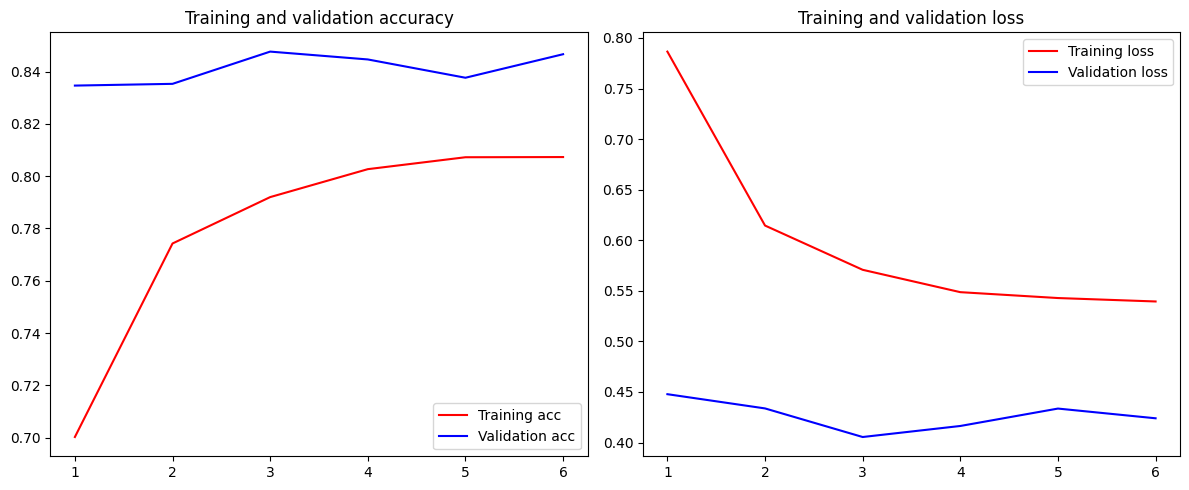

In [76]:
visualize(history3_2)

## Model 4.1 Fine Tuning

In [12]:
# Last Layers
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(0.3))
# model.add(layers.Dense(6, activation='softmax'))

In [28]:
train_set,validation_set=prep_data(False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [29]:
base_model = VGG16(weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3))

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [30]:
# with block5_conv1 i will start to train model
# you can see block5_conv1 from above

base_model.trainable = True
set_trainable = False

for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [31]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(6, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 16,813,638
Trainable params: 9,178,374
Non-trainable params: 7,635,264
_________________________________________________________________


In [32]:
fine_tune_31 = model.fit(
    train_set,
    epochs=20,
    validation_data=validation_set,
    )

Epoch 1/20
439/439 [==============================] - 62s 140ms/step - loss: 0.5022 - accuracy: 0.8271 - val_loss: 0.3448 - val_accuracy: 0.8770
Epoch 2/20
439/439 [==============================] - 61s 140ms/step - loss: 0.3338 - accuracy: 0.8945 - val_loss: 0.3060 - val_accuracy: 0.8963
Epoch 3/20
439/439 [==============================] - 62s 140ms/step - loss: 0.2952 - accuracy: 0.9052 - val_loss: 0.4081 - val_accuracy: 0.8920
Epoch 4/20
439/439 [==============================] - 62s 141ms/step - loss: 0.2637 - accuracy: 0.9178 - val_loss: 0.4359 - val_accuracy: 0.9000
Epoch 5/20
439/439 [==============================] - 62s 141ms/step - loss: 0.2382 - accuracy: 0.9268 - val_loss: 0.5087 - val_accuracy: 0.8673
Epoch 6/20
439/439 [==============================] - 62s 141ms/step - loss: 0.2117 - accuracy: 0.9394 - val_loss: 0.5202 - val_accuracy: 0.8937
Epoch 7/20
439/439 [==============================] - 62s 141ms/step - loss: 0.2044 - accuracy: 0.9443 - val_loss: 0.6234 - val_ac

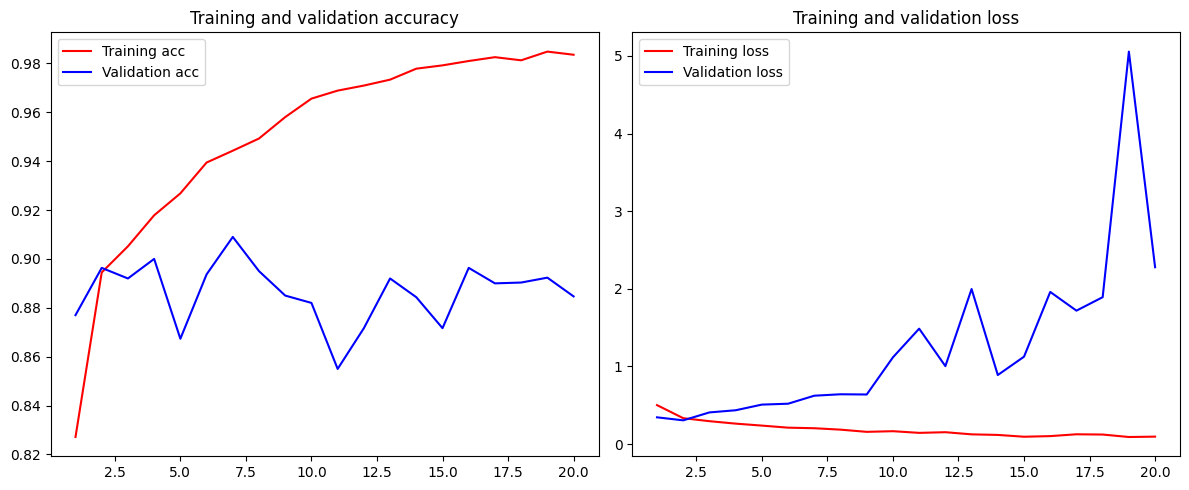

In [33]:
visualize(fine_tune_31)

it clearly overfits , i will try to prevent overfitting

### Model 4.2 Fine Tuning with more basic model 

reduce Dense layers neuron number and increase DropOut layer

In [11]:
# Last Layers
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(6, activation='softmax'))

In [38]:
train_set,validation_set=prep_data(False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [39]:
base_model = VGG16(weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3))

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [40]:
# with block5_conv1 i will start to train model
# you can see block5_conv1 from above

base_model.trainable = True
set_trainable = False

for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [41]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 6)                 774       
                                                                 
Total params: 15,764,166
Trainable params: 8,128,902
Non-trainable params: 7,635,264
_________________________________________________________________


In [44]:
fine_tune_42 = model.fit(
    train_set,
    epochs=20,
    validation_data=validation_set,
    callbacks=[callback]
    )

Epoch 1/20
439/439 [==============================] - 63s 140ms/step - loss: 0.5386 - accuracy: 0.8211 - val_loss: 0.3828 - val_accuracy: 0.8710
Epoch 2/20
439/439 [==============================] - 61s 140ms/step - loss: 0.3692 - accuracy: 0.8872 - val_loss: 0.3222 - val_accuracy: 0.8973
Epoch 3/20
439/439 [==============================] - 61s 140ms/step - loss: 0.3085 - accuracy: 0.9021 - val_loss: 0.3026 - val_accuracy: 0.9053
Epoch 4/20
439/439 [==============================] - 61s 140ms/step - loss: 0.2939 - accuracy: 0.9104 - val_loss: 0.3549 - val_accuracy: 0.8930
Epoch 5/20
439/439 [==============================] - 62s 140ms/step - loss: 0.2688 - accuracy: 0.9210 - val_loss: 0.4454 - val_accuracy: 0.8963
Epoch 6/20
439/439 [==============================] - 62s 140ms/step - loss: 0.2633 - accuracy: 0.9282 - val_loss: 0.4819 - val_accuracy: 0.9003


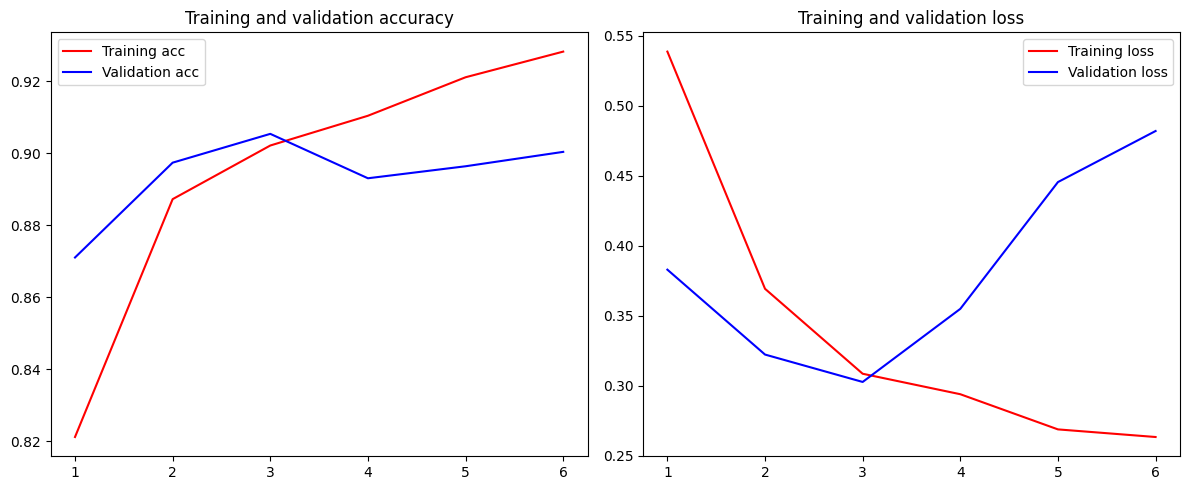

In [46]:
visualize(fine_tune_42)

## Model 4.3 Fine Tune with Data Augmentation

In [10]:
#    Last Layers
# model.add(layers.Dense(256, activation='relu'))    
# model.add(layers.Dropout(0.3))

In [52]:
train_set,validation_set=prep_data(True)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [53]:
base_model = VGG16(weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3))

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [54]:
# with block5_conv1 i will start to train model
# you can see block5_conv1 from above

base_model.trainable = True
set_trainable = False

for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [55]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(6, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 16,813,638
Trainable params: 9,178,374
Non-trainable params: 7,635,264
_________________________________________________________________


In [56]:
fine_tune_43 = model.fit(
    train_set,
    epochs=20,
    validation_data=validation_set,
    )

Epoch 1/20
439/439 [==============================] - 67s 151ms/step - loss: 0.6811 - accuracy: 0.7505 - val_loss: 0.3668 - val_accuracy: 0.8677
Epoch 2/20
439/439 [==============================] - 69s 158ms/step - loss: 0.4781 - accuracy: 0.8356 - val_loss: 0.3955 - val_accuracy: 0.8850
Epoch 3/20
439/439 [==============================] - 69s 157ms/step - loss: 0.4329 - accuracy: 0.8548 - val_loss: 0.5070 - val_accuracy: 0.8920
Epoch 4/20
439/439 [==============================] - 70s 159ms/step - loss: 0.4310 - accuracy: 0.8632 - val_loss: 0.5751 - val_accuracy: 0.8513
Epoch 5/20
439/439 [==============================] - 69s 156ms/step - loss: 0.4139 - accuracy: 0.8645 - val_loss: 0.4133 - val_accuracy: 0.8587
Epoch 6/20
439/439 [==============================] - 71s 161ms/step - loss: 0.4130 - accuracy: 0.8713 - val_loss: 0.3642 - val_accuracy: 0.8967
Epoch 7/20
439/439 [==============================] - 71s 161ms/step - loss: 0.3877 - accuracy: 0.8761 - val_loss: 0.4768 - val_ac

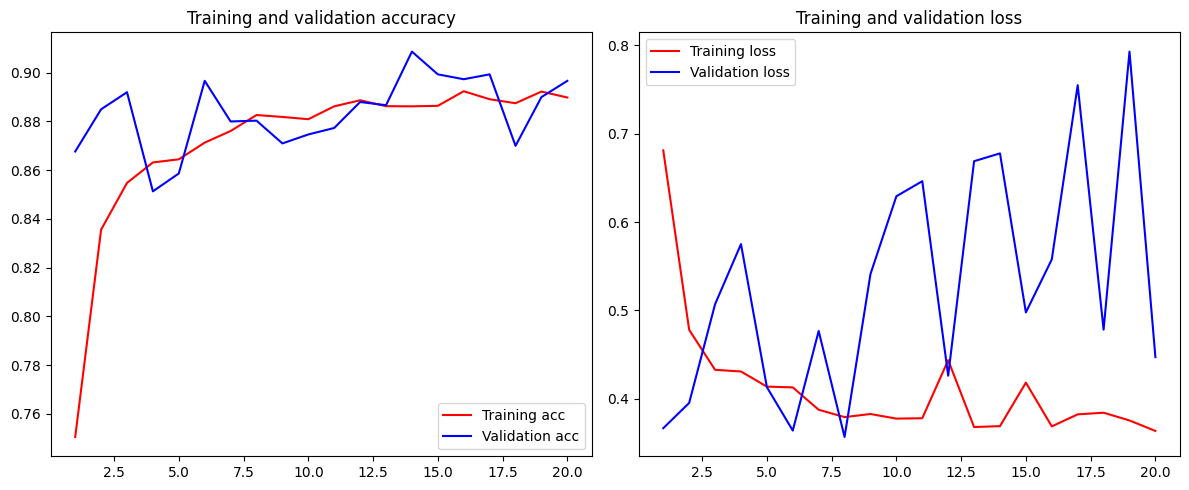

In [57]:
visualize(fine_tune_43)

## Model 4.4 Fine Tuning (start training from before 'block5_conv1')

in this model i will train model before 'block5_conv1'  , i will train it from block4_conv1 (Conv2D) layer

In [21]:
# Last Layers
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(6, activation='softmax'))
 

In [13]:
train_set,validation_set=prep_data(False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [16]:
base_model = VGG16(weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3))

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [17]:
# with block4_conv1 i will start to train model
# you can see block4_conv1 from above

base_model.trainable = True
set_trainable = False

for layer in base_model.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [18]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 15,764,166
Trainable params: 14,028,678
Non-trainable params: 1,735,488
_________________________________________________________________


In [20]:
fine_tune_44 = model.fit(
    train_set,
    epochs=20,
    validation_data=validation_set,
    callbacks=[callback]
    )

Epoch 1/20
439/439 [==============================] - 158s 341ms/step - loss: 0.8012 - accuracy: 0.7120 - val_loss: 0.3998 - val_accuracy: 0.8677
Epoch 2/20
439/439 [==============================] - 77s 176ms/step - loss: 0.4841 - accuracy: 0.8517 - val_loss: 1.0894 - val_accuracy: 0.7660
Epoch 3/20
439/439 [==============================] - 78s 177ms/step - loss: 0.4360 - accuracy: 0.8685 - val_loss: 0.3992 - val_accuracy: 0.8907
Epoch 4/20
439/439 [==============================] - 77s 176ms/step - loss: 0.4387 - accuracy: 0.8742 - val_loss: 0.4379 - val_accuracy: 0.8493
Epoch 5/20
439/439 [==============================] - 77s 176ms/step - loss: 0.3963 - accuracy: 0.8853 - val_loss: 0.5011 - val_accuracy: 0.8443
Epoch 6/20
439/439 [==============================] - 78s 177ms/step - loss: 0.4607 - accuracy: 0.8778 - val_loss: 0.4079 - val_accuracy: 0.8877


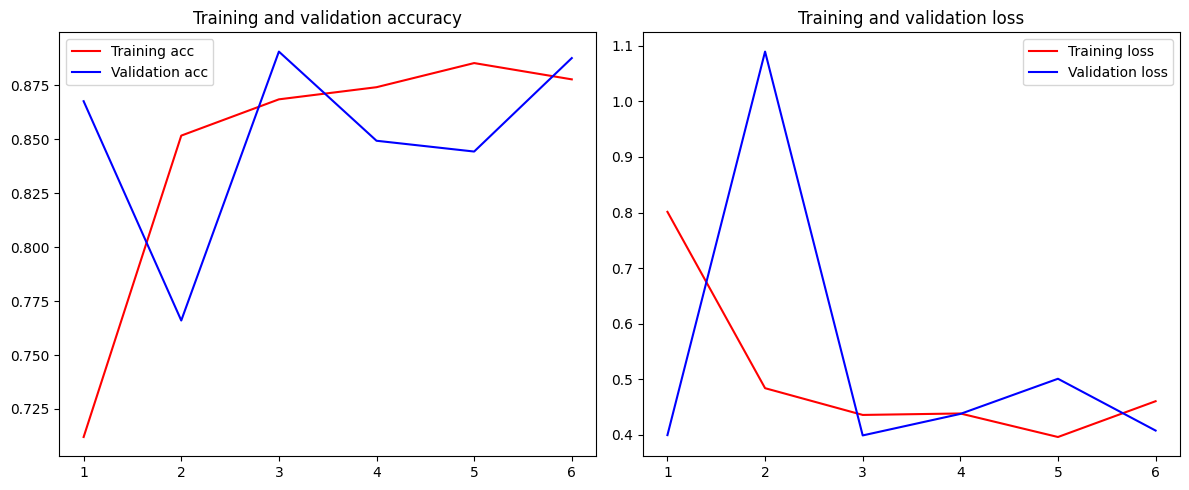

In [22]:
visualize(fine_tune_44)